# Previsão de renda

**Fonte:** Módulo 16 do Curso Cientista de Dados da EBAC

### 4 elementos importantes
- Esse notebook
- Streamlit com as análises
- Seu Github com o projeto
- Vídeo no readme do github mostrando o streamlit

## Etapa 1 CRISP - DM: Entendimento do negócio

O principal objetivo de um estudo de análise de renda para uma instituição financeira é avaliar a capacidade do cliente de arcar com as suas obrigações financeiras, como empréstimos ou financiamentos. Esta análise é crucial para determinar o risco de crédito e, consequentemente, decidir sobre a concessão de crédito e as condições oferecidas.

Por isso, a importância de, tendo posse de determinadas variáveis, estimar a renda - e esse é o **objetivo**.

## Etapa 2 Crisp-DM: Entendimento dos dados

### Dicionário de dados

Vamos trabalhar com a base 'previsao_de_renda.csv', nesse projeto. Vamos usar os seguintes recursos.

|variável|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

#### Carregando os pacotes
É considerado uma boa prática carregar os pacotes que serão utilizados como a primeira coisa do programa.

In [1]:
# bibliotecas básicas para EAD
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport # pandas_profiling deprecado
from scipy import stats

# bibliotecas para modelagem
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import time
import optuna

#bibliotecas para pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
import joblib

#### Carregando os dados
O comando pd.read_csv é um comando da biblioteca pandas (pd.) e carrega os dados do arquivo csv indicado para um objeto *dataframe* do pandas.

In [2]:
renda = pd.read_csv('previsao_de_renda.csv')

In [3]:
renda.head()

,Unnamed: 0,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,3,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,4,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


In [4]:
# verificando as informações do dataframe
renda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15000 non-null  int64  
 1   data_ref               15000 non-null  object 
 2   id_cliente             15000 non-null  int64  
 3   sexo                   15000 non-null  object 
 4   posse_de_veiculo       15000 non-null  bool   
 5   posse_de_imovel        15000 non-null  bool   
 6   qtd_filhos             15000 non-null  int64  
 7   tipo_renda             15000 non-null  object 
 8   educacao               15000 non-null  object 
 9   estado_civil           15000 non-null  object 
 10  tipo_residencia        15000 non-null  object 
 11  idade                  15000 non-null  int64  
 12  tempo_emprego          12427 non-null  float64
 13  qt_pessoas_residencia  15000 non-null  float64
 14  renda                  15000 non-null  float64
dtypes:

#### Separando os dados não vistos

In [5]:
# transformando o tipo de data, e tornando essa coluna em índice
renda['data_ref'] = pd.to_datetime(renda['data_ref'])
renda.set_index('data_ref', inplace=True)

In [6]:
# estabelecendo a data de corte
print(renda.index.max())
data_holdout = renda.index.max() - pd.DateOffset(months=3) # últimos 3 meses)
print(data_holdout)
unseen_data = renda[renda.index>=data_holdout]
print("Dados não vistos:", unseen_data.shape)
renda = renda[renda.index<data_holdout]
print("Renda:", renda.shape)

2016-03-01 00:00:00
2015-12-01 00:00:00
Dados não vistos: (4000, 14)
Renda: (11000, 14)


In [7]:
# Resetando o index, e dropando a coluna 'Data' em treino e teste
renda.reset_index(inplace=True, drop=True)
unseen_data.reset_index(inplace=True, drop=True)

## Etapa 3 Crisp-DM: Preparação dos dados
Nessa etapa realizamos tipicamente as seguintes operações com os dados:

 - **seleção**: Já temos os dados selecionados adequadamente?
 - **limpeza**: Precisaremos identificar e tratar dados faltantes
 - **construção**: construção de novas variáveis
 - **integração**: Temos apenas uma fonte de dados, não é necessário integração
 - **formatação**: Os dados já se encontram em formatos úteis?



#### Valores duplicados

In [8]:
# verificando linhas duplicadas a partir de 'id_cliente'
renda.duplicated(subset='id_cliente').sum()

2980

In [9]:
# dropando as repetições, mantendo o último registro do dia
renda.drop_duplicates(subset='id_cliente', keep='last', inplace=True)

In [10]:
# resetando o index data para index contagem
renda.reset_index(drop=True, inplace=True)

#### Colunas desnecessárias

In [11]:
# retirando colunas desnecessárias
renda.drop(['Unnamed: 0', 'id_cliente'], axis=1, inplace=True)
unseen_data.drop(['id_cliente', 'Unnamed: 0'], axis=1, inplace=True)

In [12]:
# Salvar os dados não vistos para futura verificação
unseen_data.to_csv("unseen_data.csv", index=False)

#### Valores ausentes

In [13]:
# verificando missing values
renda.isna().sum()

sexo                        0
posse_de_veiculo            0
posse_de_imovel             0
qtd_filhos                  0
tipo_renda                  0
educacao                    0
estado_civil                0
tipo_residencia             0
idade                       0
tempo_emprego            1364
qt_pessoas_residencia       0
renda                       0
dtype: int64

In [14]:
renda.shape

(8020, 12)

#### Variável `tempo_emprego`

In [15]:
# percentual de dados faltantes na variável 'tempo_emprego'
print(f'Percentual de dados faltantes em "tempo_emprego" relacionado a todo dataframe: {round(renda.tempo_emprego.isna().sum()*100 / renda.shape[0],2)}%')

Percentual de dados faltantes em "tempo_emprego" relacionado a todo dataframe: 17.01%


**Atenção:**<br/>
Não se pode ignorar 17% do dataframe. É um percentual relevante.

#### Matriz de Correlação

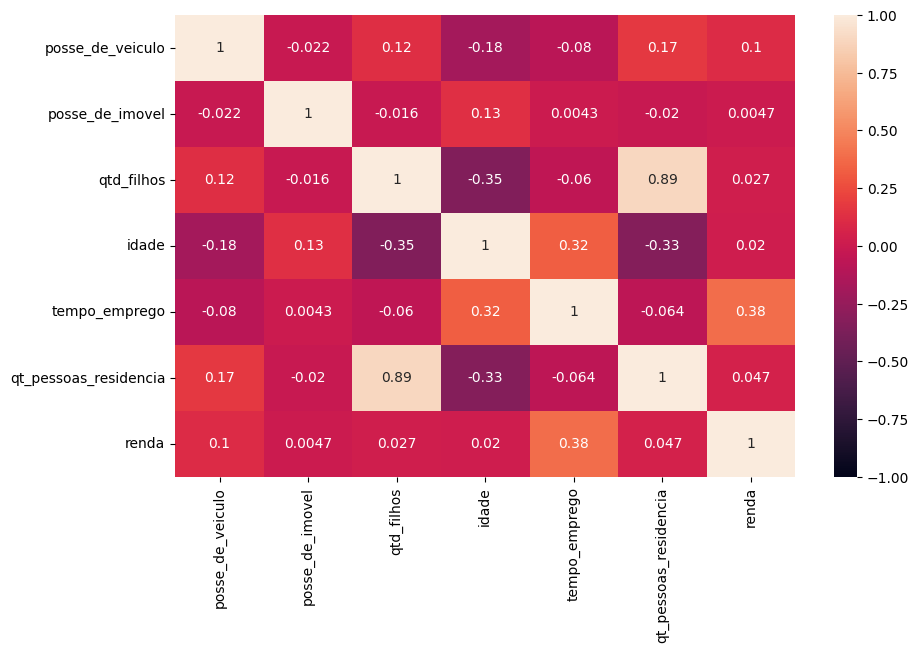

In [16]:
# Verificando correlações entre features numéricas
plt.figure(figsize = (10,6))
sns.heatmap(renda.corr(numeric_only=True), annot = True, vmin = -1, vmax = 1);

In [17]:
renda.corr(numeric_only=True).loc[:,'renda'].to_frame().T

,posse_de_veiculo,posse_de_imovel,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
renda,0.102885,0.004659,0.027024,0.01962,0.383251,0.046922,1.0


**Conclusão:**<br/>
Dentre as variáveis explicativas numéricas, `tempo_emprego` é a de maior correlação com a variável resposta.<br/>
Logo, faz-se NECESSÁRIO anteciparmos um **tratamento de dados pontual**.

#### Comportamento dos valores faltantes

In [18]:
# declarando objeto com variáveis categóricas
renda.select_dtypes(exclude=np.number).columns

Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao',
       'estado_civil', 'tipo_residencia'],
      dtype='object')

In [19]:
for i, col in enumerate(renda.select_dtypes(exclude=np.number).columns):
    print(f'O número de classes em "{col}" com valores faltantes é de: {renda[renda.tempo_emprego.isna()][col].nunique()} de \
um total de {renda[col].nunique()}.')
#     print(f'O número de classes em "{renda[col]}" com valores faltantes é de: \
# {renda[renda.tempo_emprego.isnull()][col].nunique()} de um total de {renda[col].nunique()}.')

O número de classes em "sexo" com valores faltantes é de: 2 de um total de 2.
O número de classes em "posse_de_veiculo" com valores faltantes é de: 2 de um total de 2.
O número de classes em "posse_de_imovel" com valores faltantes é de: 2 de um total de 2.
O número de classes em "tipo_renda" com valores faltantes é de: 1 de um total de 5.
O número de classes em "educacao" com valores faltantes é de: 4 de um total de 5.
O número de classes em "estado_civil" com valores faltantes é de: 5 de um total de 5.
O número de classes em "tipo_residencia" com valores faltantes é de: 5 de um total de 6.


**Conclusão:**<br/>
Existe apenas uma classe em `tipo_renda` que contém todos os valores faltantes da base de dados!<br/>
A seguir, descobriremos quem será essa classe:

In [20]:
# A classe que contém todos os valores faltantes
valores_faltantes = renda[renda.tempo_emprego.isnull()].shape[0]

# Quantidade de pensionistas na base
n_pensionistas = renda[renda.tipo_renda == 'Pensionista'].shape[0]

# Percentual de valores faltantes em Pensionista
percentual_faltantes = valores_faltantes*100/n_pensionistas
print(f'O percentual de valores faltantes em Pensionista é: {percentual_faltantes:.2f}%')

O percentual de valores faltantes em Pensionista é: 99.63%


<div class="alert alert-block alert-warning">
<b>Nota:</b> 99,6% dos valores de `tempo_emprego` em classe 'Pensionistas' são valores faltantes.
</div>

**Insight:**<br/>
De fato, se é Pensionista, para fins de comprovação de renda, não é necessário tempo de emprego.

In [21]:
# aferindo os valores mínimo, médio e mediana de 'tempo_emprego'
renda.tempo_emprego.min(), renda.tempo_emprego.mean(), renda.tempo_emprego.median()

(0.1178082191780822, 7.7320584167544775, 6.023287671232877)

In [22]:
# atribuindo um valor escolhido a todo Pensionista
valor_escolhido = renda.tempo_emprego.min()
renda.tempo_emprego.replace(np.nan, valor_escolhido, inplace=True)

<div class="alert alert-block alert-info"> <b>Nota:</b> O ideal era substituir o NaN por 0 (zero); mas por causa da transformação na variável (logaritmo), será pelo valor mínimo. </div>

In [23]:
# verificando missing values de novo
renda.isna().sum().sum()

0

In [24]:
# verificando as informações do dataframe novamente
renda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8020 entries, 0 to 8019
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sexo                   8020 non-null   object 
 1   posse_de_veiculo       8020 non-null   bool   
 2   posse_de_imovel        8020 non-null   bool   
 3   qtd_filhos             8020 non-null   int64  
 4   tipo_renda             8020 non-null   object 
 5   educacao               8020 non-null   object 
 6   estado_civil           8020 non-null   object 
 7   tipo_residencia        8020 non-null   object 
 8   idade                  8020 non-null   int64  
 9   tempo_emprego          8020 non-null   float64
 10  qt_pessoas_residencia  8020 non-null   float64
 11  renda                  8020 non-null   float64
dtypes: bool(2), float64(3), int64(2), object(5)
memory usage: 642.4+ KB


In [25]:
# Salvar a base de dados 'renda' tratada para futura verificação
renda.to_csv("renda_tratada.csv", index=False)

#### Testes

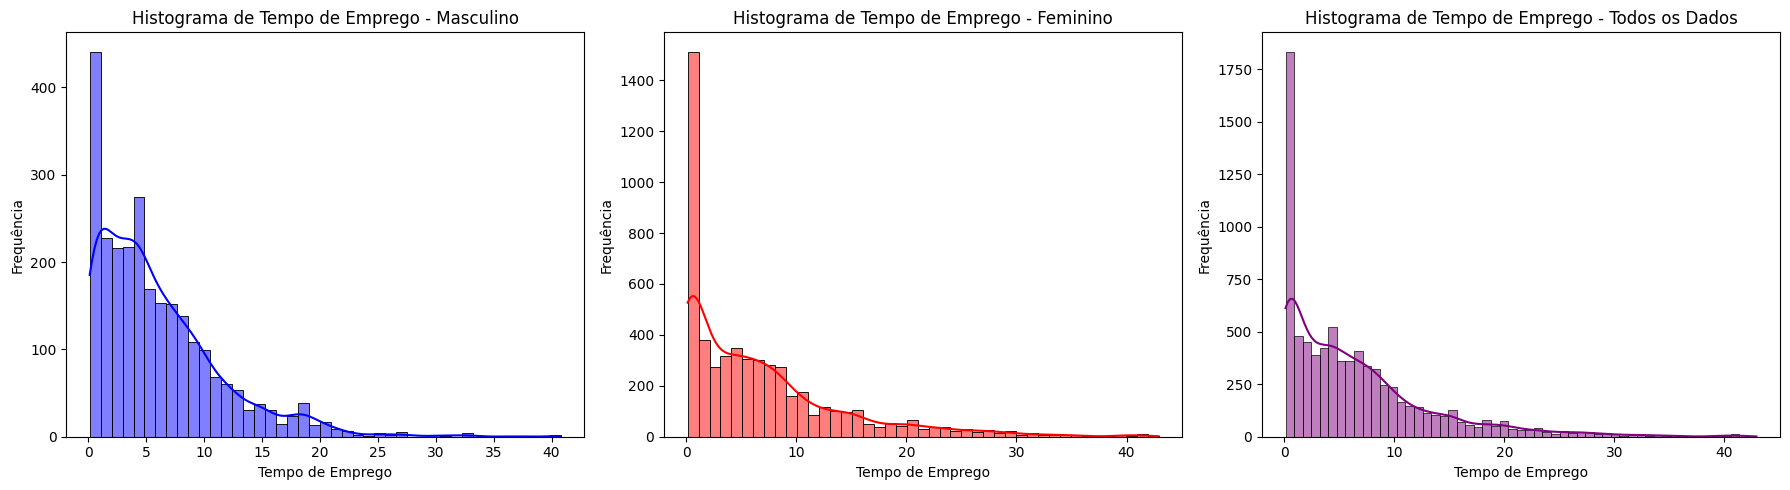

Teste de Normalidade (Shapiro-Wilk) para Tempo de Emprego para Masculino:
Estatística W = 0.8733, p-valor = 0.0000
Rejeitamos a hipótese nula: A distribuição de tempo de emprego (sexo M) não é normal.

Teste de Normalidade (Shapiro-Wilk) para Tempo de Emprego para Feminino:
Estatística W = 0.8247, p-valor = 0.0000
Rejeitamos a hipótese nula: A distribuição de tempo de emprego (sexo F) não é normal.

Teste de Normalidade (Shapiro-Wilk) para Tempo de Emprego para Todos os dados:
Estatística W = 0.8331, p-valor = 0.0000
Rejeitamos a hipótese nula: A distribuição de tempo de emprego (Todos) não é normal.



C:\Users\aflim\anaconda3\envs\streamlitenv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [26]:
# Aplicar Teste de Normalidade (Shapiro-Wilk)

# Separar grupos
tempo_M = renda[renda['sexo'] == 'M']['tempo_emprego']
tempo_F = renda[renda['sexo'] == 'F']['tempo_emprego']

# Concatenando os dados de masculino e feminino para análise conjunta
tempo = np.concatenate([tempo_M, tempo_F])

# Criando os histogramas
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Histograma para machos
sns.histplot(tempo_M, kde=True, color='blue', ax=axs[0])
axs[0].set_title("Histograma de Tempo de Emprego - Masculino")
axs[0].set_xlabel("Tempo de Emprego")
axs[0].set_ylabel("Frequência")

# Histograma para fêmeas
sns.histplot(tempo_F, kde=True, color='red', ax=axs[1])
axs[1].set_title("Histograma de Tempo de Emprego - Feminino")
axs[1].set_xlabel("Tempo de Emprego")
axs[1].set_ylabel("Frequência")

# Histograma combinado (peso total)
sns.histplot(tempo, kde=True, color='purple', ax=axs[2])
axs[2].set_title("Histograma de Tempo de Emprego - Todos os Dados")
axs[2].set_xlabel("Tempo de Emprego")
axs[2].set_ylabel("Frequência")

plt.tight_layout()
plt.show()

# Teste de Normalidade (Shapiro-Wilk)
alpha = 0.05  # Nível de significância

# Teste para masculino
shapiro_male = stats.shapiro(tempo_M)
p_value_male = shapiro_male.pvalue

# Teste para feminino
shapiro_female = stats.shapiro(tempo_F)
p_value_female = shapiro_female.pvalue

# Teste para tempo_emprego para todos os dados
shapiro_all = stats.shapiro(tempo)
p_value_all = shapiro_all.pvalue

# Exibir resultados do teste de normalidade
print(f"Teste de Normalidade (Shapiro-Wilk) para Tempo de Emprego para Masculino:")
print(f"Estatística W = {shapiro_male.statistic:.4f}, p-valor = {p_value_male:.4f}")
if p_value_male < alpha:
    print("Rejeitamos a hipótese nula: A distribuição de tempo de emprego (sexo M) não é normal.\n")
else:
    print("Não rejeitamos a hipótese nula: A distribuição de tempo de emprego (sexo M) pode ser considerada normal.\n")

print(f"Teste de Normalidade (Shapiro-Wilk) para Tempo de Emprego para Feminino:")
print(f"Estatística W = {shapiro_female.statistic:.4f}, p-valor = {p_value_female:.4f}")
if p_value_female < alpha:
    print("Rejeitamos a hipótese nula: A distribuição de tempo de emprego (sexo F) não é normal.\n")
else:
    print("Não rejeitamos a hipótese nula: A distribuição de tempo de emprego (sexo F) pode ser considerada normal.\n")

print(f"Teste de Normalidade (Shapiro-Wilk) para Tempo de Emprego para Todos os dados:")
print(f"Estatística W = {shapiro_all.statistic:.4f}, p-valor = {p_value_all:.4f}")
if p_value_all < alpha:
    print("Rejeitamos a hipótese nula: A distribuição de tempo de emprego (Todos) não é normal.\n")
else:
    print("Não rejeitamos a hipótese nula: A distribuição de tempo de emprego (Todos) pode ser considerada normal.\n")

<div class="alert alert-block alert-warning">
<b>Conclusão Parcial:</b> A principal variável explicativa do conjunto de dados não tem distribuição normal.
</div>

#### Características das variáveis categóricas

In [27]:
# Proporção de classes
for i, col in enumerate(renda.select_dtypes(exclude='number').columns):
    print(f'Percentual de "{col}":\n {renda[col].value_counts(normalize=True)*100}\n ')

Percentual de "sexo":
 sexo
F    67.269327
M    32.730673
Name: proportion, dtype: float64
 
Percentual de "posse_de_veiculo":
 posse_de_veiculo
False    60.673317
True     39.326683
Name: proportion, dtype: float64
 
Percentual de "posse_de_imovel":
 posse_de_imovel
True     67.356608
False    32.643392
Name: proportion, dtype: float64
 
Percentual de "tipo_renda":
 tipo_renda
Assalariado         51.334165
Empresário          22.867830
Pensionista         17.069825
Servidor público     8.665835
Bolsista             0.062344
Name: proportion, dtype: float64
 
Percentual de "educacao":
 educacao
Secundário             61.670823
Superior completo      33.366584
Superior incompleto     3.703242
Primário                1.109726
Pós graduação           0.149626
Name: proportion, dtype: float64
 
Percentual de "estado_civil":
 estado_civil
Casado      69.862843
Solteiro    11.995012
União        7.306733
Separado     6.234414
Viúvo        4.600998
Name: proportion, dtype: float64
 
Percentua

In [28]:
# Coerência entre 'posse_de_imovel' e 'tipo_residencia'
pd.crosstab(renda['tipo_residencia'], renda['posse_de_imovel'])

posse_de_imovel,False,True
tipo_residencia,,
Aluguel,50,55
Casa,2141,5107
Com os pais,243,112
Comunitário,17,21
Estúdio,28,26
Governamental,139,81


<div class="alert alert-block alert-warning">
<b>Conclusão Parcial:</b> Não há coerência exata entre as informações.<br/>
Mas nota-se a forte tendência entre morar em Casa tendo a posse do próprio imóvel, e que quem mora com os pais tende a não ter o próprio imóvel..
</div>

In [29]:
# Coerência entre 'estado_civil' e 'tipo_renda' e a média de 'renda'
pd.crosstab(renda['estado_civil'], renda['tipo_renda'], values=renda.renda, aggfunc='mean')

tipo_renda,Assalariado,Bolsista,Empresário,Pensionista,Servidor público
estado_civil,,,,,
Casado,6335.321905,4097.752,6276.394888,3955.417445,7359.767972
Separado,5029.097528,NaN,5686.656917,3173.283000,9617.224545
Solteiro,5243.584830,NaN,5212.331962,3230.908951,7667.418652
União,5010.960915,NaN,5488.124561,3636.543765,7321.830652
Viúvo,4683.950435,NaN,5396.702069,2800.775663,4539.520345


### Entendimento dos dados - Bivariadas

<Axes: xlabel='tempo_emprego', ylabel='renda'>

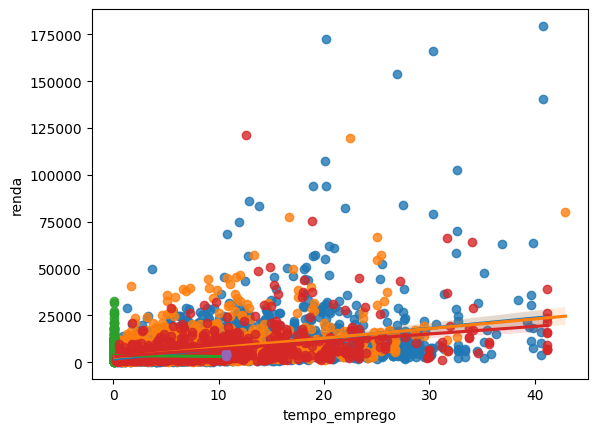

In [30]:
fig, ax = plt.subplots()

sns.regplot(data=renda[renda.tipo_renda == 'Assalariado'], x='tempo_emprego', y='renda', ax=ax)
sns.regplot(data=renda[renda.tipo_renda == 'Empresário'], x='tempo_emprego', y='renda', ax=ax)
sns.regplot(data=renda[renda.tipo_renda == 'Pensionista'], x='tempo_emprego', y='renda', ax=ax)
sns.regplot(data=renda[renda.tipo_renda == 'Servidor público'], x='tempo_emprego', y='renda', ax=ax)
sns.regplot(data=renda[renda.tipo_renda == 'Bolsista'], x='tempo_emprego', y='renda', ax=ax)

In [31]:
# transformação de variáveis núméricas essenciais
renda['tempo_emprego_log'] = np.log(renda.tempo_emprego)
renda['renda_log'] = np.log(renda.renda)

<Axes: xlabel='tempo_emprego_log', ylabel='renda'>

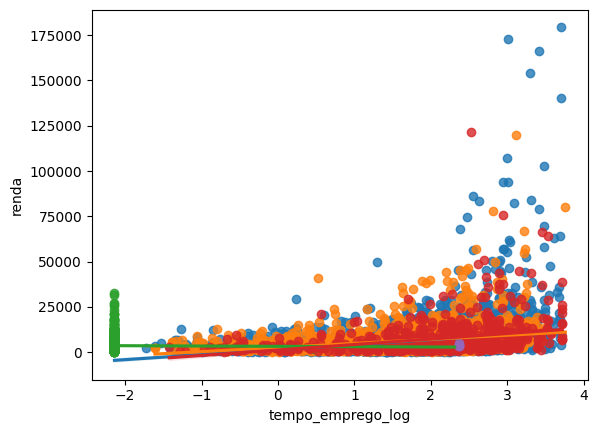

In [32]:
fig, ax = plt.subplots()

sns.regplot(data=renda[renda.tipo_renda == 'Assalariado'], x='tempo_emprego_log', y='renda', ax=ax)
sns.regplot(data=renda[renda.tipo_renda == 'Empresário'], x='tempo_emprego_log', y='renda', ax=ax)
sns.regplot(data=renda[renda.tipo_renda == 'Pensionista'], x='tempo_emprego_log', y='renda', ax=ax)
sns.regplot(data=renda[renda.tipo_renda == 'Servidor público'], x='tempo_emprego_log', y='renda', ax=ax)
sns.regplot(data=renda[renda.tipo_renda == 'Bolsista'], x='tempo_emprego_log', y='renda', ax=ax)

<Axes: xlabel='tempo_emprego_log', ylabel='renda_log'>

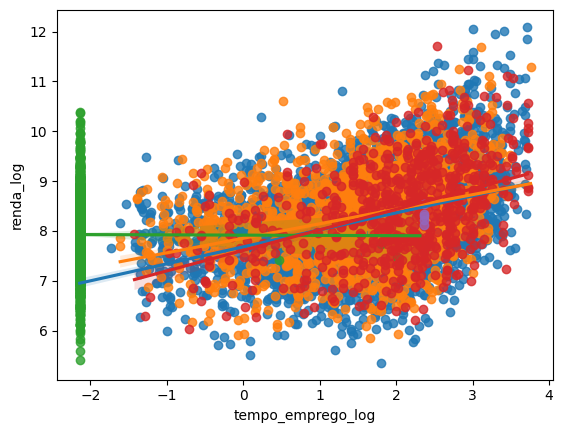

In [33]:
fig, ax = plt.subplots()

sns.regplot(data=renda[renda.tipo_renda == 'Assalariado'], x='tempo_emprego_log', y='renda_log', ax=ax)
sns.regplot(data=renda[renda.tipo_renda == 'Empresário'], x='tempo_emprego_log', y='renda_log', ax=ax)
sns.regplot(data=renda[renda.tipo_renda == 'Pensionista'], x='tempo_emprego_log', y='renda_log', ax=ax)
sns.regplot(data=renda[renda.tipo_renda == 'Servidor público'], x='tempo_emprego_log', y='renda_log', ax=ax)
sns.regplot(data=renda[renda.tipo_renda == 'Bolsista'], x='tempo_emprego_log', y='renda_log', ax=ax)

<Axes: xlabel='tempo_emprego', ylabel='renda_log'>

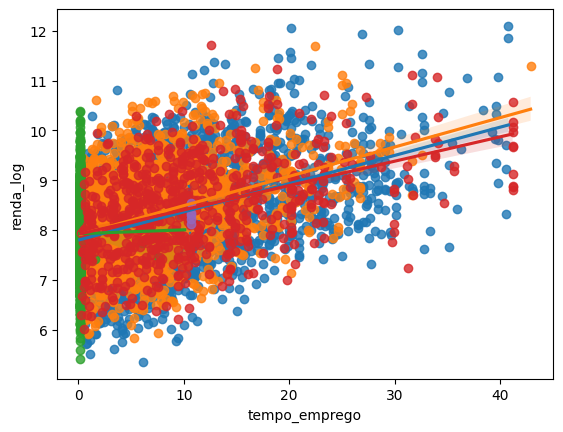

In [34]:
fig, ax = plt.subplots()

sns.regplot(data=renda[renda.tipo_renda == 'Assalariado'], x='tempo_emprego', y='renda_log', ax=ax)
sns.regplot(data=renda[renda.tipo_renda == 'Empresário'], x='tempo_emprego', y='renda_log', ax=ax)
sns.regplot(data=renda[renda.tipo_renda == 'Pensionista'], x='tempo_emprego', y='renda_log', ax=ax)
sns.regplot(data=renda[renda.tipo_renda == 'Servidor público'], x='tempo_emprego', y='renda_log', ax=ax)
sns.regplot(data=renda[renda.tipo_renda == 'Bolsista'], x='tempo_emprego', y='renda_log', ax=ax)

In [35]:
# correlação com variável target original e transformada
renda.corr(numeric_only=True).loc[:,['renda','renda_log']].T

,posse_de_veiculo,posse_de_imovel,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_log,renda_log
renda,0.102885,0.004659,0.027024,0.019620,0.387864,0.046922,1.000000,0.253705,0.731129
renda_log,0.149008,0.022617,0.049798,-0.004378,0.409441,0.067307,0.731129,0.313240,1.000000


**Insight:**<br/>
Aumentou a correlação entre `tempo_emprego` e `renda_log`.

#### Codificação de variáveis categóricas

In [36]:
# mapping
renda_map = {
    'Assalariado': 'Assalariado',
    'Empresário': 'Empresário',
    'Pensionista': 'Pensionista',
    'Servidor público':'ServPub_Bolsa',
    'Bolsista':'ServPub_Bolsa'}

educacao_map = {
    'Secundário': 'Secundário',
    'Superior completo': 'Superior completo',
    'Superior incompleto': 'Outros',
    'Primário': 'Outros',
    'Pós graduação': 'Outros'}

estado_civil_map = {
    'Casado':'Casado/União',
    'Separado':'Independente',
    'Solteiro':'Independente',
    'União':'Casado/União',
    'Viúvo':'Independente'}

residencia_map = {
    'Aluguel':'Outro',
    'Casa':'Casa',
    'Com os pais':'Outro',
    'Comunitário':'Outro',
    'Estúdio':'Outro',
    'Governamental':'Outro'}

renda.tipo_renda = renda.tipo_renda.map(renda_map)
renda.educacao = renda.educacao.map(educacao_map)
renda.tipo_residencia = renda.tipo_residencia.map(residencia_map)
renda.estado_civil = renda.estado_civil.map(estado_civil_map)

In [37]:
# Como ficaram as classes das variáveis categóricas
for i, col in enumerate(renda.select_dtypes(exclude=np.number).columns):
    print(f'Percentual de "{col}":\n {renda[col].value_counts(normalize=True)*100}\n ')

Percentual de "sexo":
 sexo
F    67.269327
M    32.730673
Name: proportion, dtype: float64
 
Percentual de "posse_de_veiculo":
 posse_de_veiculo
False    60.673317
True     39.326683
Name: proportion, dtype: float64
 
Percentual de "posse_de_imovel":
 posse_de_imovel
True     67.356608
False    32.643392
Name: proportion, dtype: float64
 
Percentual de "tipo_renda":
 tipo_renda
Assalariado      51.334165
Empresário       22.867830
Pensionista      17.069825
ServPub_Bolsa     8.728180
Name: proportion, dtype: float64
 
Percentual de "educacao":
 educacao
Secundário           61.670823
Superior completo    33.366584
Outros                4.962594
Name: proportion, dtype: float64
 
Percentual de "estado_civil":
 estado_civil
Casado/União    77.169576
Independente    22.830424
Name: proportion, dtype: float64
 
Percentual de "tipo_residencia":
 tipo_residencia
Casa     90.374065
Outro     9.625935
Name: proportion, dtype: float64
 


#### Obtendo a base de dados codificada ("get_dummies")

In [38]:
# Obtendo a "renda codificada"
renda_cod = pd.get_dummies(renda, drop_first=True)

In [39]:
print(renda_cod.shape)
renda_cod.columns

(8020, 17)


Index(['posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'idade',
       'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'tempo_emprego_log',
       'renda_log', 'sexo_M', 'tipo_renda_Empresário',
       'tipo_renda_Pensionista', 'tipo_renda_ServPub_Bolsa',
       'educacao_Secundário', 'educacao_Superior completo',
       'estado_civil_Independente', 'tipo_residencia_Outro'],
      dtype='object')

#### Trabalhando uma transformação na melhor variável explicativa e na variável resposta

In [40]:
pd.set_option('display.max_columns', renda_cod.shape[1])

In [41]:
# correlação com a base de dados codificada
renda_cod.corr(numeric_only=True).loc[:,['renda','renda_log']].T

,posse_de_veiculo,posse_de_imovel,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_log,renda_log,sexo_M,tipo_renda_Empresário,tipo_renda_Pensionista,tipo_renda_ServPub_Bolsa,educacao_Secundário,educacao_Superior completo,estado_civil_Independente,tipo_residencia_Outro
renda,0.102885,0.004659,0.027024,0.019620,0.387864,0.046922,1.000000,0.253705,0.731129,0.284046,0.018878,-0.112679,0.061477,-0.027038,0.039283,-0.054428,-0.011017
renda_log,0.149008,0.022617,0.049798,-0.004378,0.409441,0.067307,0.731129,0.313240,1.000000,0.379183,0.045504,-0.147872,0.080296,-0.062291,0.074135,-0.058237,-0.000608


**Conclusão:**<br/>
Por enquanto, foco nessas variáveis explicativas, baseado em correlação: **'tempo_emprego', 'sexo_M', 'posse_de_veiculo' e 'tipo_renda_Pensionista'**

#### Separar treino e teste

In [42]:
# Separar X e y
X = renda_cod.drop(['renda', 'tempo_emprego_log', 'renda_log'], axis=1)
y = renda_cod['renda_log']

In [43]:
# Dividir treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [44]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5614, 14), (2406, 14), (5614,), (2406,))

In [45]:
X_train.head(2)

,posse_de_veiculo,posse_de_imovel,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,sexo_M,tipo_renda_Empresário,tipo_renda_Pensionista,tipo_renda_ServPub_Bolsa,educacao_Secundário,educacao_Superior completo,estado_civil_Independente,tipo_residencia_Outro
7432,False,False,0,34,5.216438,1.0,True,False,False,False,False,True,True,False
2986,False,False,1,39,11.183562,2.0,False,False,False,False,True,False,True,False


In [46]:
X_test.head(2)

,posse_de_veiculo,posse_de_imovel,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,sexo_M,tipo_renda_Empresário,tipo_renda_Pensionista,tipo_renda_ServPub_Bolsa,educacao_Secundário,educacao_Superior completo,estado_civil_Independente,tipo_residencia_Outro
2896,False,True,2,39,6.347945,4.0,True,False,False,False,True,False,False,False
5104,True,True,0,40,6.717808,2.0,False,False,False,False,True,False,False,False


## Etapa 4 Crisp-DM: Modelagem
Nessa etapa que realizaremos a construção do modelo. Os passos típicos são:
- Selecionar a técnica de modelagem
- Desenho do teste
- Avaliação do modelo


### Modelagem

<div class="alert alert-block alert-info"> <b>Nota:</b> Escolheu-se usar o algorítmo Floresta Aleatória; e otimização dos hiperparâmetros com Optuna. </div>

#### Default Model

In [47]:
# Random Forest with default hyperparameters
rf_default = RandomForestRegressor(monotonic_cst=None, random_state=123)
start_time = time.time()
rf_default.fit(X_train, y_train)
end_time = time.time()
print(f'Time taken to fit the model with default hyperparameters: {end_time - start_time:.4f} seconds')

Time taken to fit the model with default hyperparameters: 1.7153 seconds


In [48]:
# Regression metrics for default hyperparameters
y_train_pred_default = rf_default.predict(X_train)
y_test_pred_default = rf_default.predict(X_test)
print('\nR-squared with Default Hyperparameters:')
print('Training Set:')
print(r2_score(y_train, y_train_pred_default))
print('Testing Set:')
print(r2_score(y_test, y_test_pred_default))


R-squared with Default Hyperparameters:
Training Set:
0.729361009511627
Testing Set:
0.23669994113934778


#### Model with Optuna

In [49]:
# Define the objective function for Optuna
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 6, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 15, 300)
    n_estimators = trial.suggest_int('n_estimators', 30, 70)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    
    rf = RandomForestRegressor(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        n_estimators=n_estimators,
        max_features=max_features,
        monotonic_cst=None,
        random_state=123
    )
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    return sum(scores) / len(scores) # average of the scores

# Perform hyperparameter optimization using Optuna
start_time = time.time()
study = optuna.create_study(direction='maximize') # maximize the scoring ('recall')
study.optimize(objective, n_trials=20)
end_time = time.time()
print(f'Time taken to perform Optuna Optimization: {end_time - start_time:.4f} seconds')


# Print the best hyperparameters and best score
print("Best Hyperparameters:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-04-23 16:20:53,017] A new study created in memory with name: no-name-1660cf13-0d73-46f2-bb9e-80e16f03b060
[I 2025-04-23 16:20:53,687] Trial 0 finished with value: 0.29778797034973054 and parameters: {'max_depth': 10, 'min_samples_leaf': 12, 'min_samples_split': 208, 'n_estimators': 57, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.29778797034973054.
[I 2025-04-23 16:20:54,333] Trial 1 finished with value: 0.3024062380472414 and parameters: {'max_depth': 6, 'min_samples_leaf': 9, 'min_samples_split': 107, 'n_estimators': 55, 'max_features': 'log2'}. Best is trial 1 with value: 0.3024062380472414.
[I 2025-04-23 16:20:54,895] Trial 2 finished with value: 0.30738554298291876 and parameters: {'max_depth': 6, 'min_samples_leaf': 20, 'min_samples_split': 49, 'n_estimators': 47, 'max_features': 'log2'}. Best is trial 2 with value: 0.30738554298291876.
[I 2025-04-23 16:20:55,499] Trial 3 finished with value: 0.29299538628860244 and parameters: {'max_depth': 9, 'min_samples_leaf

Time taken to perform Optuna Optimization: 11.7702 seconds
Best Hyperparameters: {'max_depth': 8, 'min_samples_leaf': 11, 'min_samples_split': 41, 'n_estimators': 52, 'max_features': 'sqrt'}
Best Score: 0.3266139692364211


In [50]:
# Train the model with the best hyperparameters
best_rf = RandomForestRegressor(
    max_depth=study.best_params['max_depth'],
    min_samples_leaf=study.best_params['min_samples_leaf'],
    min_samples_split=study.best_params['min_samples_split'],
    n_estimators=study.best_params['n_estimators'],
    max_features=study.best_params['max_features'],
    monotonic_cst=None,
    random_state=123
)
best_rf.fit(X_train, y_train)

# Evaluate the model
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

print('\nR-squared after Optuna Optimization:')
print('Training Set:')
print(r2_score(y_train, y_train_pred))
print('Testing Set:')
print(r2_score(y_test, y_test_pred))


R-squared after Optuna Optimization:
Training Set:
0.3775348931434981
Testing Set:
0.3395162150733402


#### Feature Importances

#### Importância de *features* com base na diminuição média de impurezas

In [51]:
# Built-in feature importance (Gini Importance)
feature_names = [f"{X.columns[i]}" for i in range(X.shape[1])]
importances = best_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_rf.estimators_], axis=0)
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df)

                       Feature  Gini Importance
4                tempo_emprego         0.453969
6                       sexo_M         0.347958
3                        idade         0.063393
0             posse_de_veiculo         0.036890
8       tipo_renda_Pensionista         0.020636
11  educacao_Superior completo         0.012560
5        qt_pessoas_residencia         0.011360
9     tipo_renda_ServPub_Bolsa         0.010516
2                   qtd_filhos         0.009517
7        tipo_renda_Empresário         0.008574
1              posse_de_imovel         0.007631
10         educacao_Secundário         0.007065
12   estado_civil_Independente         0.005923
13       tipo_residencia_Outro         0.004009


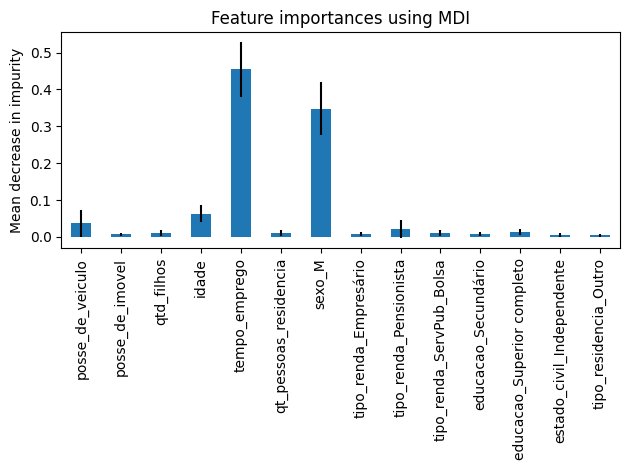

In [52]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Importância de *features* com base na permutação de *features*

In [53]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    best_rf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 3.000 seconds


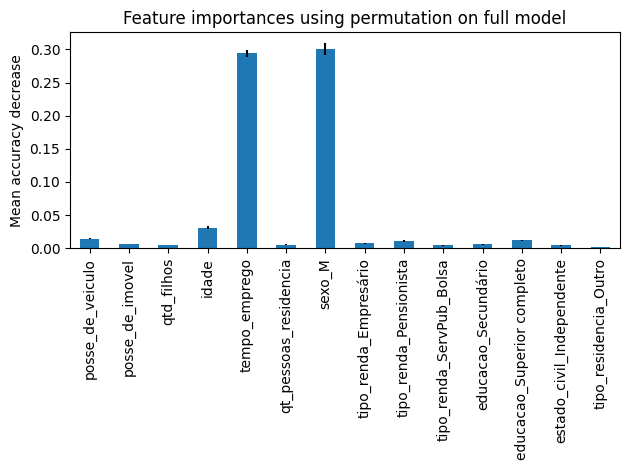

In [54]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
<b>Achado:</b> Encontramos 2 variáveis independentes de maior relevância para o modelo.
</div>

#### Modelagem usando 2 *features*

In [55]:
# Select the 2 mains features: 'tempo_emprego' e 'sexo_M'

X_train = X_train[['sexo_M', 'tempo_emprego']]
X_test = X_test[['sexo_M', 'tempo_emprego']]

In [56]:
# Random Forest with default hyperparameters
rf_default = RandomForestRegressor( monotonic_cst=None, random_state=123)
start_time = time.time()
rf_default.fit(X_train, y_train)
end_time = time.time()
print(f'Time taken to fit the model with default hyperparameters: {end_time - start_time:.4f} seconds')

Time taken to fit the model with default hyperparameters: 0.7353 seconds


In [57]:
# Regression metrics for default hyperparameters
y_train_pred_default = rf_default.predict(X_train)
y_test_pred_default = rf_default.predict(X_test)
print('\nR-squared with Default Hyperparameters:')
print('Training Set:')
print(r2_score(y_train, y_train_pred_default))
print('Testing Set:')
print(r2_score(y_test, y_test_pred_default))


R-squared with Default Hyperparameters:
Training Set:
0.6256167391026035
Testing Set:
0.1837799492471096


#### Model with Optuna

In [58]:
# Define the objective function for Optuna
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 4, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 15, 300)
    n_estimators = trial.suggest_int('n_estimators', 40, 80)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    
    rf = RandomForestRegressor(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        n_estimators=n_estimators,
        max_features=max_features,
        monotonic_cst=None,
        random_state=123
    )
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    return sum(scores) / len(scores) # average of the scores

# Perform hyperparameter optimization using Optuna
start_time = time.time()
study = optuna.create_study(direction='maximize') # maximize the scoring ('recall')
study.optimize(objective, n_trials=20)
end_time = time.time()
print(f'Time taken to perform Optuna Optimization: {end_time - start_time:.4f} seconds')


# Print the best hyperparameters and best score
print("Best Hyperparameters:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-04-23 16:22:06,220] A new study created in memory with name: no-name-a3b7ce9a-5474-4831-992b-f870ee829e13
[I 2025-04-23 16:22:07,077] Trial 0 finished with value: 0.34793028014610294 and parameters: {'max_depth': 5, 'min_samples_leaf': 13, 'min_samples_split': 202, 'n_estimators': 70, 'max_features': 'log2'}. Best is trial 0 with value: 0.34793028014610294.
[I 2025-04-23 16:22:08,237] Trial 1 finished with value: 0.34639717570469547 and parameters: {'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 79, 'n_estimators': 76, 'max_features': 'log2'}. Best is trial 0 with value: 0.34793028014610294.
[I 2025-04-23 16:22:08,979] Trial 2 finished with value: 0.34394882565537666 and parameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 236, 'n_estimators': 58, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.34793028014610294.
[I 2025-04-23 16:22:09,394] Trial 3 finished with value: 0.3470055096790266 and parameters: {'max_depth': 4, 'min_samples_lea

Time taken to perform Optuna Optimization: 15.6028 seconds
Best Hyperparameters: {'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 94, 'n_estimators': 51, 'max_features': 'log2'}
Best Score: 0.3497344405106178


In [59]:
# Train the model with the best hyperparameters
best_rf = RandomForestRegressor(
    max_depth=study.best_params['max_depth'],
    min_samples_leaf=study.best_params['min_samples_leaf'],
    min_samples_split=study.best_params['min_samples_split'],
    n_estimators=study.best_params['n_estimators'],
    max_features=study.best_params['max_features'],
    monotonic_cst=None,
    random_state=123
)
best_rf.fit(X_train, y_train)

# Evaluate the model
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

print('\nR-squared after Optuna Optimization:')
print('Training Set:')
print(r2_score(y_train, y_train_pred))
print('Testing Set:')
print(r2_score(y_test, y_test_pred))


R-squared after Optuna Optimization:
Training Set:
0.36537816137658297
Testing Set:
0.35730580968111636


In [60]:
# Resultado final do modelo
best_rf

RandomForestRegressor(max_depth=4, max_features='log2', min_samples_leaf=8,
                      min_samples_split=94, n_estimators=51, random_state=123)

### Pipeline

#### Modelagem Sklearn para 2 features

In [61]:
pd.read_csv('renda_tratada.csv').head(2)

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15


In [62]:
renda = pd.read_csv('renda_tratada.csv')

In [63]:
# Separar X e y
renda['renda_log'] = np.log(renda.renda)
X = renda.drop(['renda_log'], axis=1)
y = renda['renda_log']

In [64]:
# Especificar as features importantes
num_cols = ['tempo_emprego']
cat_cols = ['sexo']

X = pd.concat([X[cat_cols], X[num_cols]], axis=1)

In [65]:
# Dividir treino e teste
X_train_sk, X_test_sk, y_train_sk, y_test_sk = train_test_split(X, y, test_size=0.3, random_state=123)

In [66]:
X_train_sk.shape, X_test_sk.shape, y_train_sk.shape, y_test_sk.shape

((5614, 2), (2406, 2), (5614,), (2406,))

In [67]:
X_train_sk.head(2)

,sexo,tempo_emprego
7432,M,5.216438
2986,F,11.183562


In [68]:
X_test_sk.head(2)

,sexo,tempo_emprego
2896,M,6.347945
5104,F,6.717808


In [69]:
tempo_min = renda.tempo_emprego.min()

num_pipeline = Pipeline(steps = [
                        ('impute', SimpleImputer(strategy='constant', fill_value=tempo_min)),
])

cat_pipeline = Pipeline(steps = [
                        ('impute', SimpleImputer(strategy='most_frequent')),
                        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

In [70]:
preprocessor  = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

In [71]:
# Aplicando o pipeline preprocessor
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

transformed_train_data = pipeline.fit_transform(X_train_sk) # X_train_sk
transformed_test_data = pipeline.transform(X_test_sk)

In [72]:
# Obtendo os passos
pipeline.named_steps

{'preprocessor': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('impute',
                                                   SimpleImputer(fill_value=0.1178082191780822,
                                                                 strategy='constant'))]),
                                  ['tempo_emprego']),
                                 ('cat',
                                  Pipeline(steps=[('impute',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('ohe',
                                                   OneHotEncoder(drop='first',
                                                                 handle_unknown='ignore',
                                                                 sparse_output=False))]),
                                  ['sexo'])])}

In [73]:
# Obter o nome das features categóricas
categorical_feature_names = pipeline.named_steps['preprocessor'] \
.named_transformers_['cat'].get_feature_names_out(cat_cols)

# Converte o nome das features para uma lista (opcional)
categorical_feature_names = list(categorical_feature_names)

In [74]:
# Concatenar todos os nomes de feature
colunas = num_cols + categorical_feature_names
print(colunas)

['tempo_emprego', 'sexo_M']


In [75]:
# Converte os dados transformados em formato de dataframe
X_train_transformed_sk = pd.DataFrame(transformed_train_data, columns = colunas, index=X_train_sk.index)
X_train_transformed_sk.head(2)

,tempo_emprego,sexo_M
7432,5.216438,1.0
2986,11.183562,0.0


In [76]:
# Converte os dados transformados em formato de dataframe
X_test_transformed_sk = pd.DataFrame(transformed_test_data, columns = colunas, index=X_test_sk.index)
X_test_transformed_sk.head(2)

,tempo_emprego,sexo_M
2896,6.347945,1.0
5104,6.717808,0.0


#### Avaliando na base de testes

In [77]:
# Evaluate the model
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

print('\nR-squared:')
print('Training Set:')
print(r2_score(y_train, y_train_pred))
print('Testing Set:')
print(r2_score(y_test, y_test_pred))


R-squared:
Training Set:
0.36537816137658297
Testing Set:
0.35730580968111636


#### Preparando os arquivos para Streamlit

In [78]:
pipefinal = make_pipeline(preprocessor, best_rf)
pipefinal

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value=0.1178082191780822,
                                                                                 strategy='constant'))]),
                                                  ['tempo_emprego']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sexo'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=4, max_features='log2',
                                       min_samples_leaf=8, min_samples_split=94,
                                       n_estimators=51, random_state=123))])

#### Usando joblib

In [79]:
joblib.dump(pipefinal, "pipe_m16_v.final.joblib")

['pipe_m16_v.final.joblib']

## Etapa 5 Crisp-DM: Avaliação dos resultados


In [80]:
unseen_data = pd.read_csv('unseen_data.csv', usecols=['tempo_emprego', 'sexo', 'renda'])
unseen_data.head(10)

,sexo,tempo_emprego,renda
0,F,9.432877,1319.94
1,M,7.178082,7390.48
2,F,3.293151,4010.06
3,F,6.290411,1434.22
4,F,11.652055,1934.62
5,M,3.386301,2688.53
6,F,14.126027,4099.21
7,F,9.523288,14038.82
8,F,NaN,1767.96
9,F,20.273973,4748.97


In [81]:
novos_dados = pd.concat([unseen_data, pd.DataFrame(np.exp(pipefinal.predict(unseen_data[['tempo_emprego', 'sexo']])), columns=['renda_predita'])], axis=1)
novos_dados['renda'] = round(novos_dados['renda'], 2)
novos_dados['renda_predita'] = round(novos_dados['renda_predita'], 2)
r_2 = r2_score(np.log(novos_dados.renda), np.log(novos_dados.renda_predita))
novos_dados['renda'] = novos_dados['renda'].apply(lambda x: '$ {:,.2f}'.format(x))
novos_dados['renda_predita'] = novos_dados['renda_predita'].apply(lambda x: '$ {:,.2f}'.format(x))
novos_dados.head()

C:\Users\aflim\anaconda3\envs\streamlitenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


,sexo,tempo_emprego,renda,renda_predita
0,F,9.432877,"$ 1,319.94","$ 5,155.57"
1,M,7.178082,"$ 7,390.48","$ 3,550.23"
2,F,3.293151,"$ 4,010.06","$ 5,155.57"
3,F,6.290411,"$ 1,434.22","$ 5,155.57"
4,F,11.652055,"$ 1,934.62","$ 5,155.57"


In [82]:
# Evaluate the model
print('\nR-squared:')
print('Dados não vistos:')
print(r_2)


R-squared:
Dados não vistos:
-0.14619006462038509


<div class="alert alert-block alert-warning">
<b>NOTA:</b> Há forte discussão entre os cientistas de dados sobre o uso da métrica "R-squared" para uso fora do contexto de Regressão Linear.
</div>

**Avaliação Final:** É possível que, justamente diante de novos dados, o modelo devesse ser refeito.

## Etapa 6 Crisp-DM: Implantação
Nessa etapa colocamos em uso o modelo desenvolvido, normalmente implementando o modelo desenvolvido em um motor que toma as decisões com algum nível de automação.

In [83]:
sexo = input("Informe o sexo ('M' ou 'F'): ")

Informe o sexo ('M' ou 'F'):  M


In [88]:
tempo = float(input("Informe o tempo de emprego: "))

Informe o tempo de emprego:  8.1


In [89]:
estimativa = round(np.exp(pipefinal
                          .predict(pd.DataFrame([[sexo, tempo]], 
                                                columns=['sexo', 'tempo_emprego'])))[0], 2)

C:\Users\aflim\anaconda3\envs\streamlitenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [90]:
print(f'A estimativa de Renda é: $ {estimativa:,.2f}]')

A estimativa de Renda é: $ 3,550.23]
